In [1]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

# Note: Some metrics need to be defined manually

In [2]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [3]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('D:/Program_Files/Python/venv/venv/data/Timeseries Forecas/TSLA1.csv')
df

,Date,Y
0,2012/1/3,1.872000
1,2012/1/4,1.847333
2,2012/1/5,1.808000
3,2012/1/6,1.794000
4,2012/1/9,1.816667
...,...,...
1251,2016/12/21,13.846667
1252,2016/12/22,13.896667
1253,2016/12/23,14.222667
1254,2016/12/27,14.635333


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [4]:
# 1.1 Convert date
df['Date']=pd.to_datetime(df.iloc[:,0])
# df

In [5]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1256 non-null   datetime64[ns]
 1   Y       1256 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


In [6]:
new_df = df
# df.rename(columns={'Close': 'Y'}, inplace=True)

# new_df=df.iloc[:,[4,3]].copy()
new_df.head()

,Date,Y
0,2012-01-03,1.872000
1,2012-01-04,1.847333
2,2012-01-05,1.808000
3,2012-01-06,1.794000
4,2012-01-09,1.816667


In [7]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df.describe()

,Date,Y
count,1256,1256.000000
mean,2014-07-02 09:14:54.267515904,10.657324
min,2012-01-03 00:00:00,1.519333
25%,2013-04-04 18:00:00,2.790167
50%,2014-07-02 12:00:00,13.120000
75%,2015-09-30 06:00:00,15.029833
max,2016-12-28 00:00:00,19.069332
std,NaN,5.637137


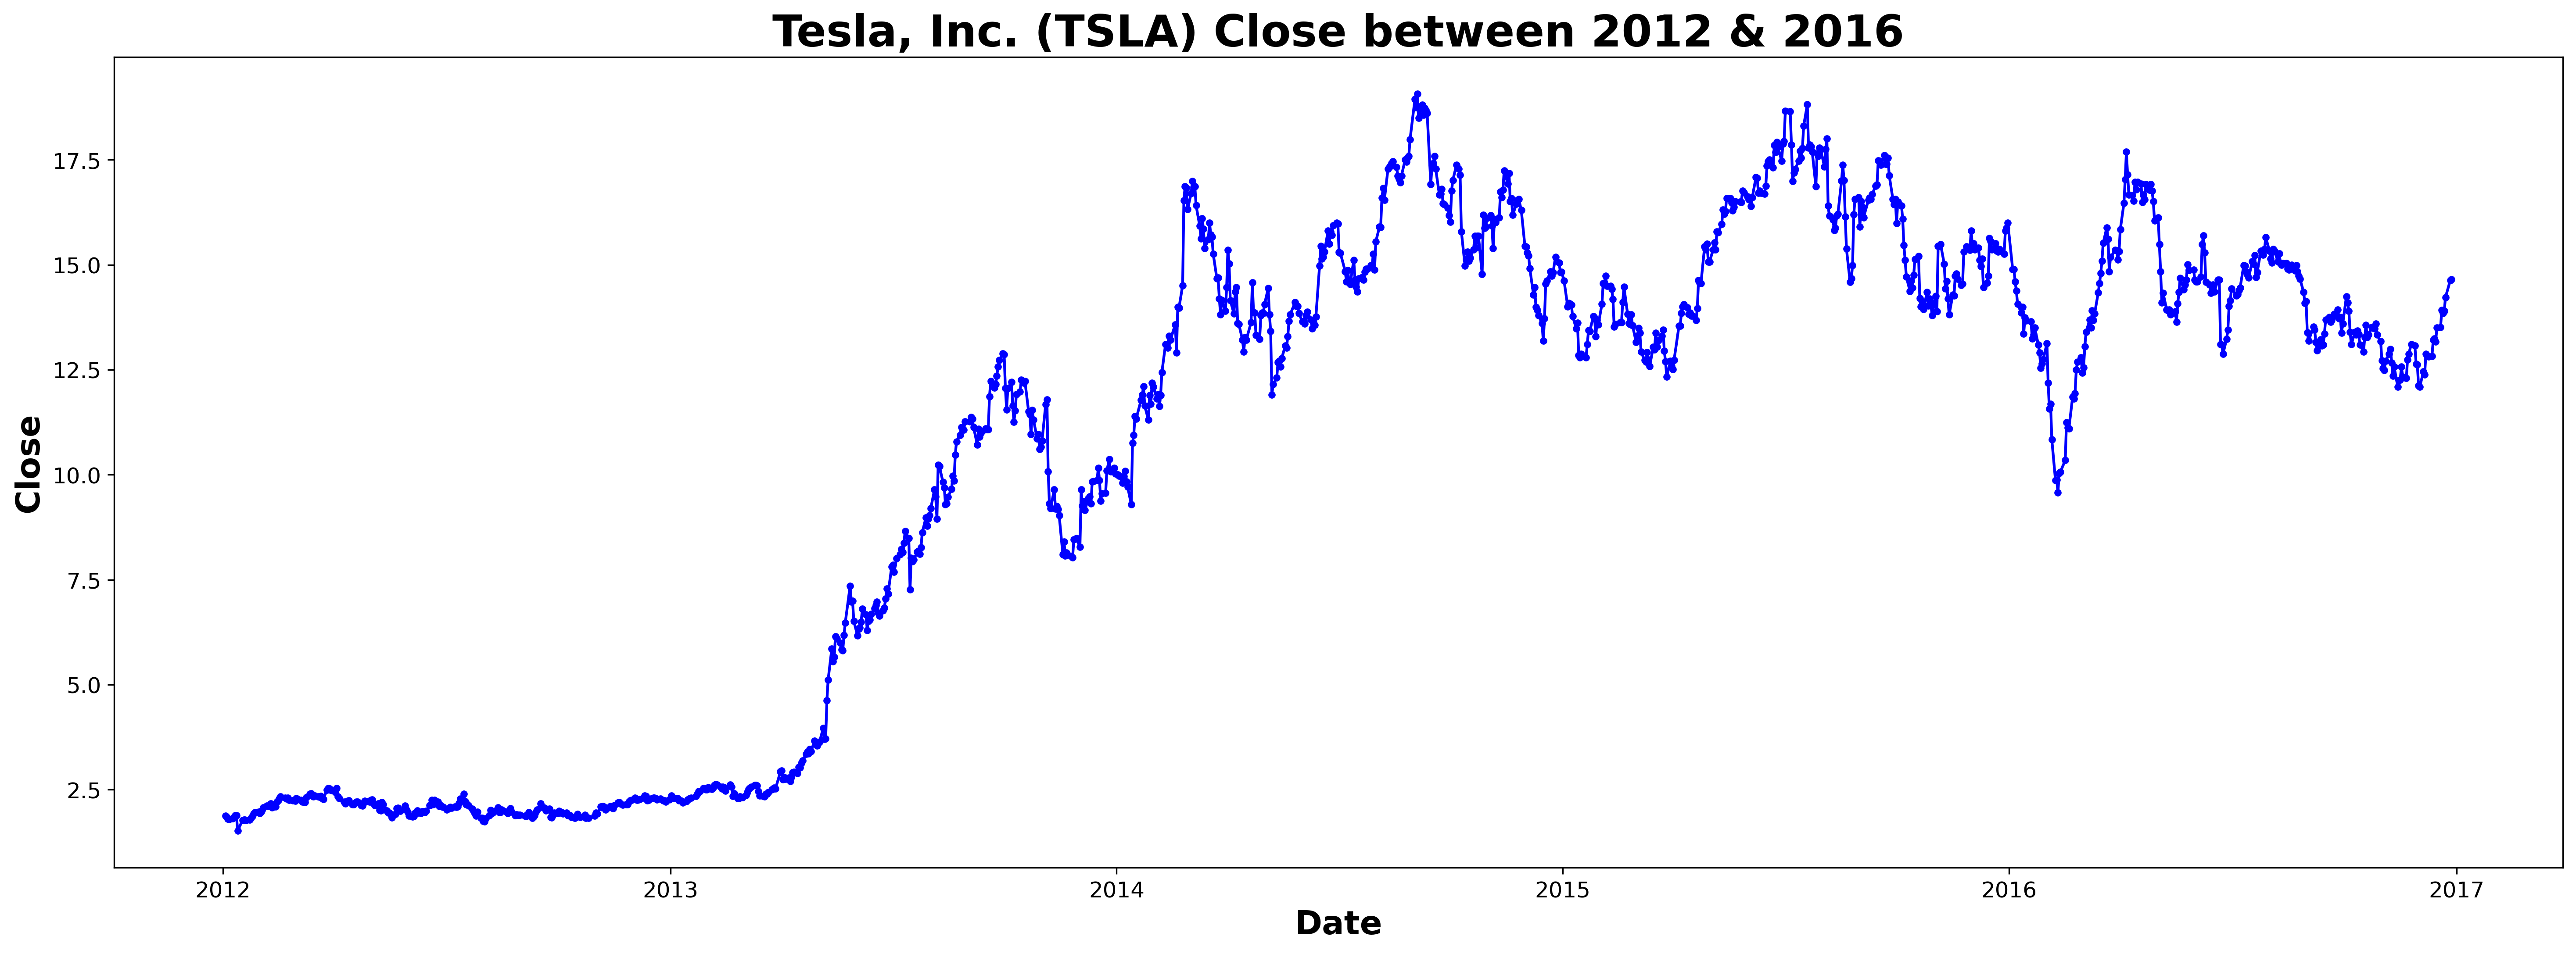

In [8]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Tesla, Inc. (TSLA) Close between 2012 & 2016',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Y'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [9]:
# Create 3 lags
new_df['Lag_1']=new_df['Y'].shift(1).copy()
new_df['Lag_2']=new_df['Y'].shift(2).copy()
new_df['Lag_3']=new_df['Y'].shift(3).copy()
new_df.head()

,Date,Y,Lag_1,Lag_2,Lag_3
0,2012-01-03,1.872000,NaN,NaN,NaN
1,2012-01-04,1.847333,1.872000,NaN,NaN
2,2012-01-05,1.808000,1.847333,1.872000,NaN
3,2012-01-06,1.794000,1.808000,1.847333,1.872000
4,2012-01-09,1.816667,1.794000,1.808000,1.847333


In [10]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Y,Lag_1,Lag_2,Lag_3
0,2012-01-06,1.794000,1.808000,1.847333,1.872000
1,2012-01-09,1.816667,1.794000,1.808000,1.847333
2,2012-01-10,1.841333,1.816667,1.794000,1.808000
3,2012-01-11,1.882000,1.841333,1.816667,1.794000
4,2012-01-12,1.883333,1.882000,1.841333,1.816667
...,...,...,...,...,...
1248,2016-12-21,13.846667,13.919333,13.515333,13.499333
1249,2016-12-22,13.896667,13.846667,13.919333,13.515333
1250,2016-12-23,14.222667,13.896667,13.846667,13.919333
1251,2016-12-27,14.635333,14.222667,13.896667,13.846667


In [630]:
# Export the data
clean_df.to_csv('',index=False, header=True)
# Colab
#clean_df.to_csv('Rainfall_Lags.csv',index=False, header=True)

# 3. Data preprocessing under time-series structure

A total of 21 years are in the data set. In this practice, we will use the last three years of data as the testing set

In [11]:
# Train data
Forecast_train_data=clean_df.iloc[0:1096,:].copy()
Forecast_train_data

,Date,Y,Lag_1,Lag_2,Lag_3
0,2012-01-06,1.794000,1.808000,1.847333,1.872000
1,2012-01-09,1.816667,1.794000,1.808000,1.847333
2,2012-01-10,1.841333,1.816667,1.794000,1.808000
3,2012-01-11,1.882000,1.841333,1.816667,1.794000
4,2012-01-12,1.883333,1.882000,1.841333,1.816667
...,...,...,...,...,...
1091,2016-05-10,13.912667,13.928000,14.328667,14.102000
1092,2016-05-11,13.930667,13.912667,13.928000,14.328667
1093,2016-05-12,13.818667,13.930667,13.912667,13.928000
1094,2016-05-13,13.840667,13.818667,13.930667,13.912667


In [12]:
# Test data
Forecast_test_data=clean_df.iloc[1096:1096+157,:].copy()
Forecast_test_data

,Date,Y,Lag_1,Lag_2,Lag_3
1096,2016-05-17,13.644000,13.886000,13.840667,13.818667
1097,2016-05-18,14.078000,13.644000,13.886000,13.840667
1098,2016-05-19,14.347333,14.078000,13.644000,13.886000
1099,2016-05-20,14.685333,14.347333,14.078000,13.644000
1100,2016-05-23,14.414667,14.685333,14.347333,14.078000
...,...,...,...,...,...
1248,2016-12-21,13.846667,13.919333,13.515333,13.499333
1249,2016-12-22,13.896667,13.846667,13.919333,13.515333
1250,2016-12-23,14.222667,13.896667,13.846667,13.919333
1251,2016-12-27,14.635333,14.222667,13.896667,13.846667


# 4. Prepare time-series data for train/validation structure manually

Here we have a total of 18 years of data in training data set that are ready to be further splitted into training and validation data set

18 years of data can be evenlly divided into 6 portions (3 years in each portion)

# Expanding window

In [43]:
# Expanding 1
# Exp_training_1=Forecast_train_data.iloc[0:105,:].copy()
# Exp_val_1=Forecast_train_data.iloc[105:105+36,:].copy()

# Expanding 2
# Exp_training_2=Forecast_train_data.iloc[0:141,:].copy()
# Exp_val_2=Forecast_train_data.iloc[141:141+36,:].copy()

# Expanding 3
# Exp_training_3=Forecast_train_data.iloc[0:177,:].copy()
# Exp_val_3=Forecast_train_data.iloc[177:177+36,:].copy()

Exp_training_13=Forecast_train_data.iloc[0:939,:].copy()
Exp_val_13=Forecast_train_data.iloc[939:939+157,:].copy()

# Rolling window

In [173]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:468,:].copy()
Rol_val_1=Forecast_train_data.iloc[468:468+157,:].copy()

# Rolling 2
# Rol_training_2=Forecast_train_data.iloc[33:141,:].copy()
# Rol_val_2=Forecast_train_data.iloc[141:141+36,:].copy()

# Rolling 3
# Rol_training_3=Forecast_train_data.iloc[69:177,:].copy()
# Rol_val_3=Forecast_train_data.iloc[177:177+36,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X) 

In [44]:
#set x (make prediction)
# Train
x_train=Exp_training_13.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_13.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_13['Y'].copy()
y_val=Exp_val_13['Y'].copy()

In [174]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']


# Validation
x_val=Rol_val_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']


#set y (want to predict)
y_train=Rol_training_1['Y'].copy()
y_val=Rol_val_1['Y'].copy()

# 6. Creating Net 

In [45]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.016448,0.018689,0.020095
1,0.015651,0.016448,0.018689
2,0.016942,0.015651,0.016448
3,0.018348,0.016942,0.015651
4,0.020665,0.018348,0.016942


In [46]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [47]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.   

# Sequential style coding for creating net

In [50]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='relu'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))

model.add(Dense(units=48, activation='relu'))

model.add(Dense(units=96, activation='relu'))

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.0005,beta_1=0.99)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 96)                4704      
                                                                 
 dense_5 (Dense)             (None, 1)                 97        
                                                                 
Total params: 6,421
Trainable params: 6,421
Non-trainabl

Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [51]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
15/15 [==============================] - 1s 12ms/step - loss: 9.4647 - mean_absolute_percentage_error: 99.3370 - val_loss: 14.3479 - val_mean_absolute_percentage_error: 99.2583
Epoch 2/300
15/15 [==============================] - 0s 3ms/step - loss: 9.3629 - mean_absolute_percentage_error: 97.6939 - val_loss: 14.2176 - val_mean_absolute_percentage_error: 98.3593
Epoch 3/300
15/15 [==============================] - 0s 3ms/step - loss: 9.2273 - mean_absolute_percentage_error: 95.4426 - val_loss: 14.0380 - val_mean_absolute_percentage_error: 97.1215
Epoch 4/300
15/15 [==============================] - 0s 3ms/step - loss: 9.0425 - mean_absolute_percentage_error: 92.3632 - val_loss: 13.7912 - val_mean_absolute_percentage_error: 95.4201
Epoch 5/300
15/15 [==============================] - 0s 3ms/step - loss: 8.7882 - mean_absolute_percentage_error: 88.2185 - val_loss: 13.4532 - val_mean_absolute_percentage_error: 93.0923
Epoch 6/300
15/15 [==============================] - 0s 3ms

In [52]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

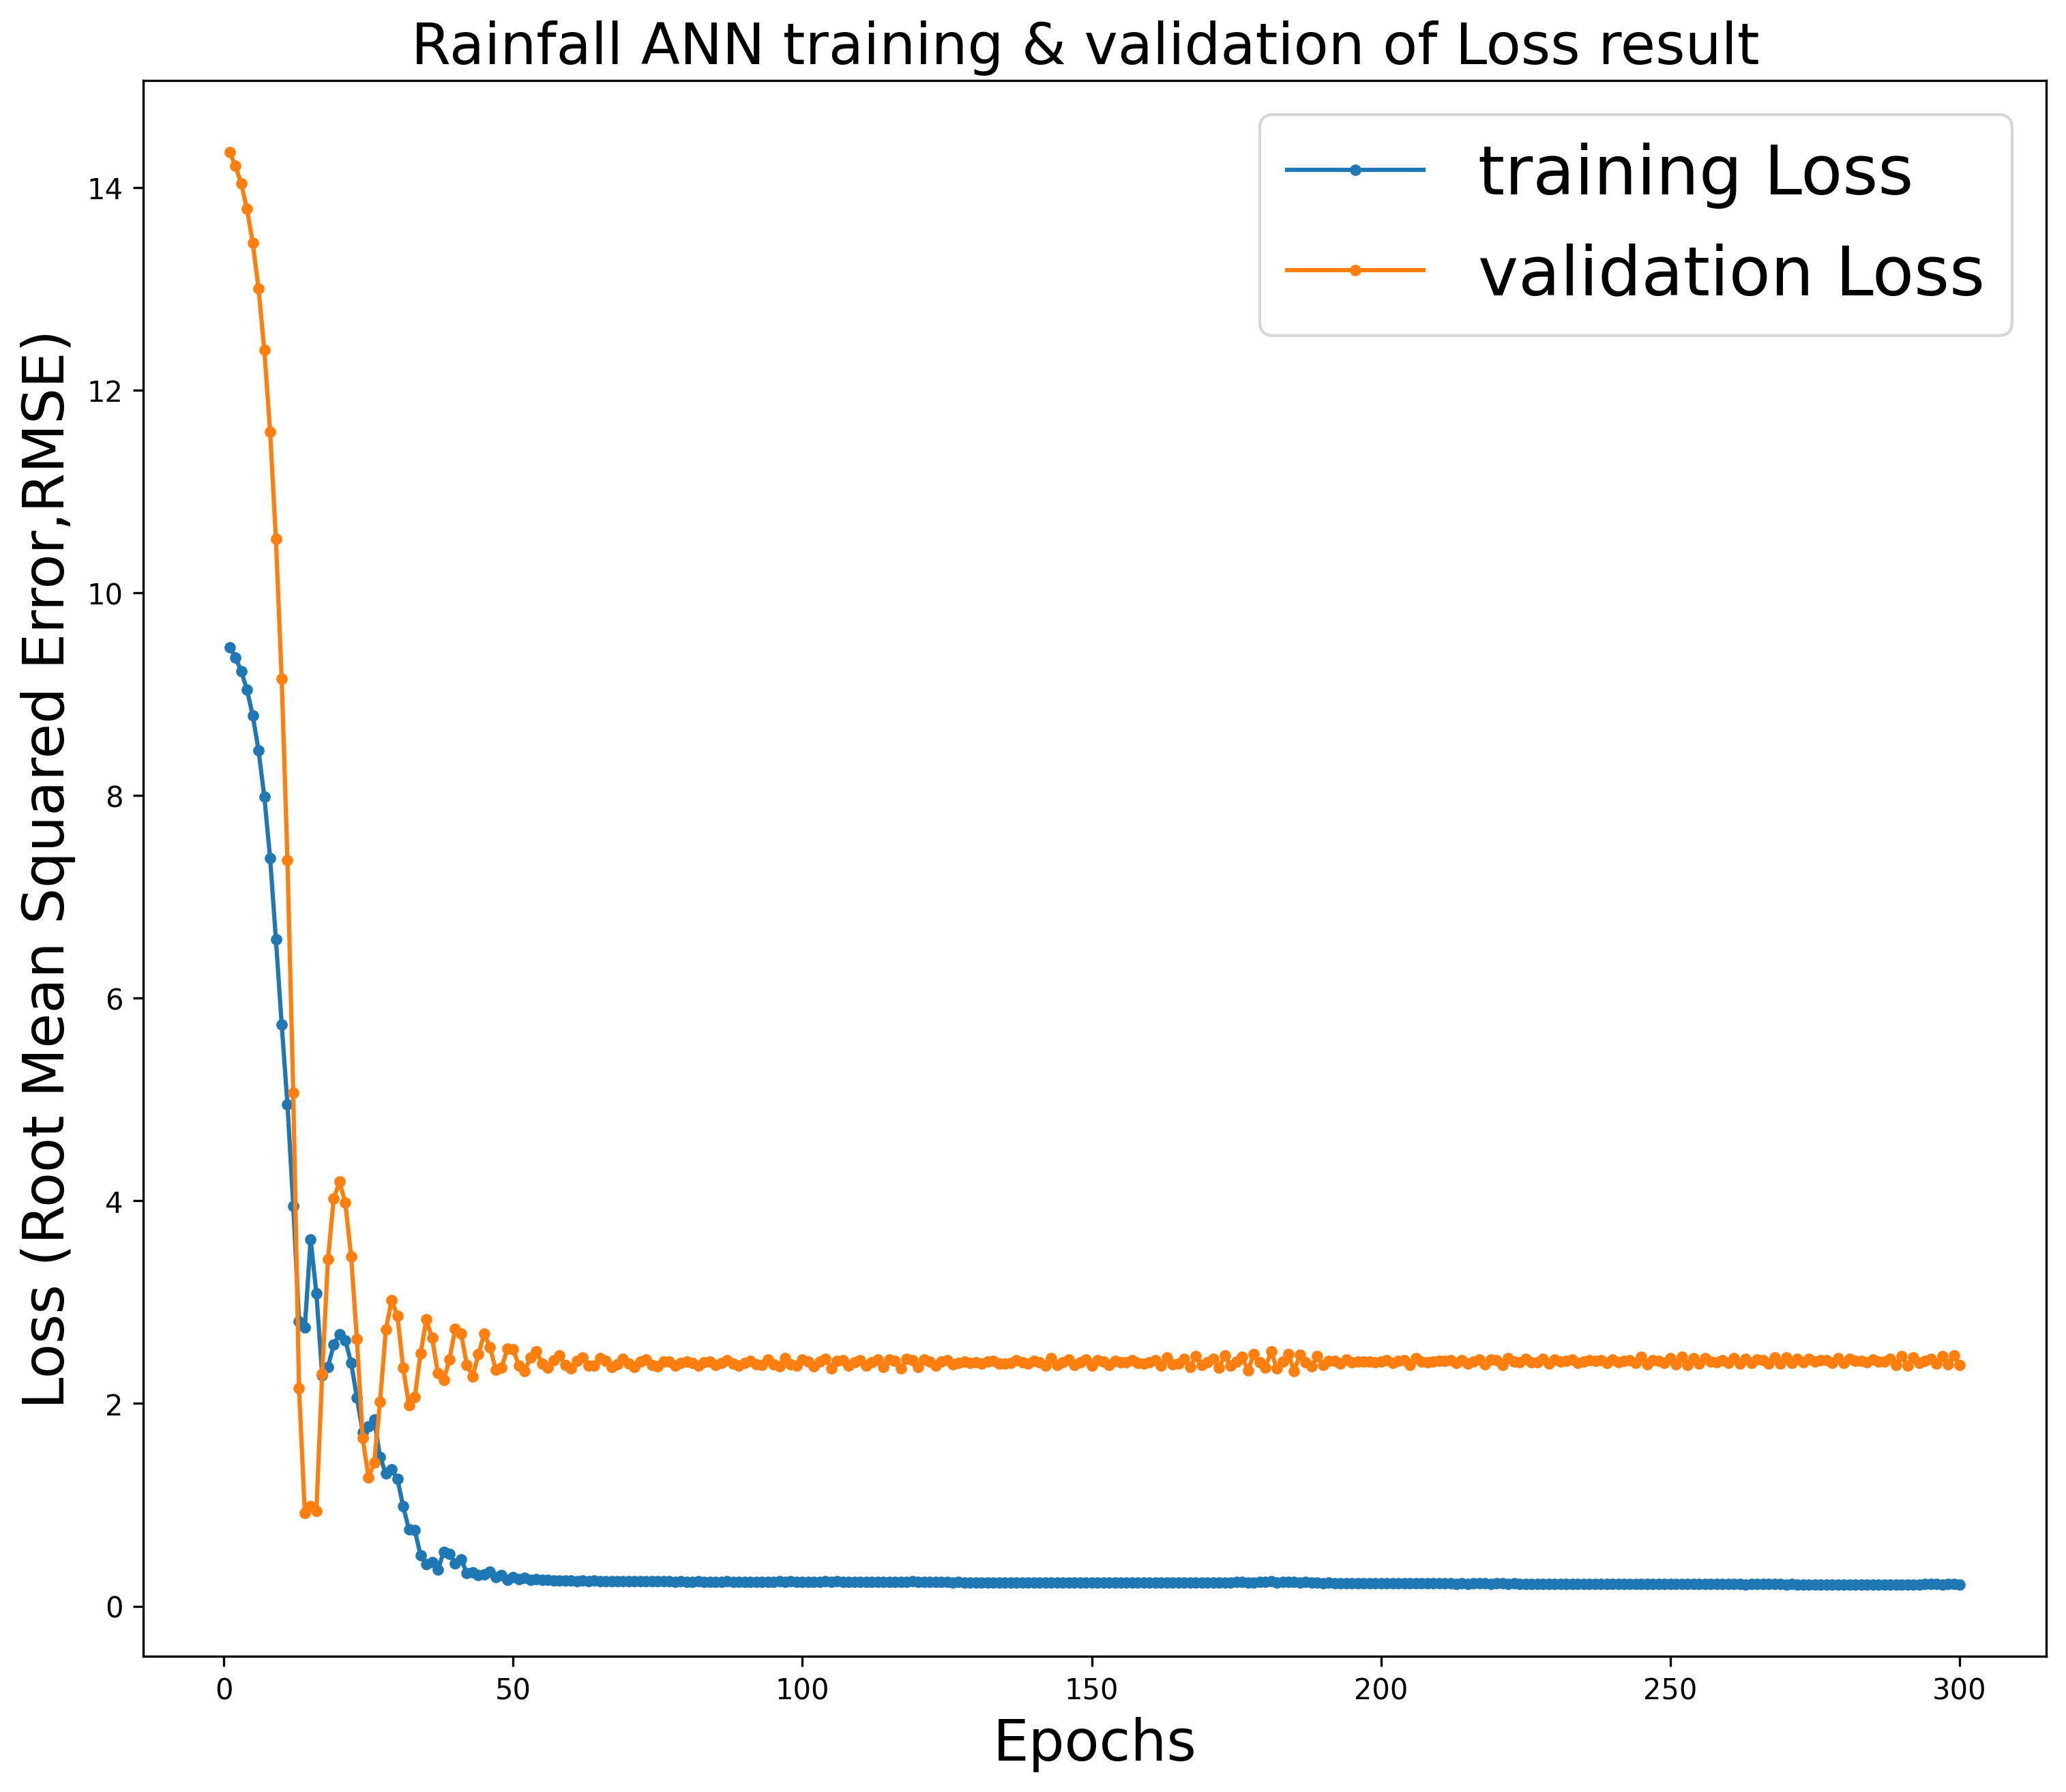

In [53]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Rainfall ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

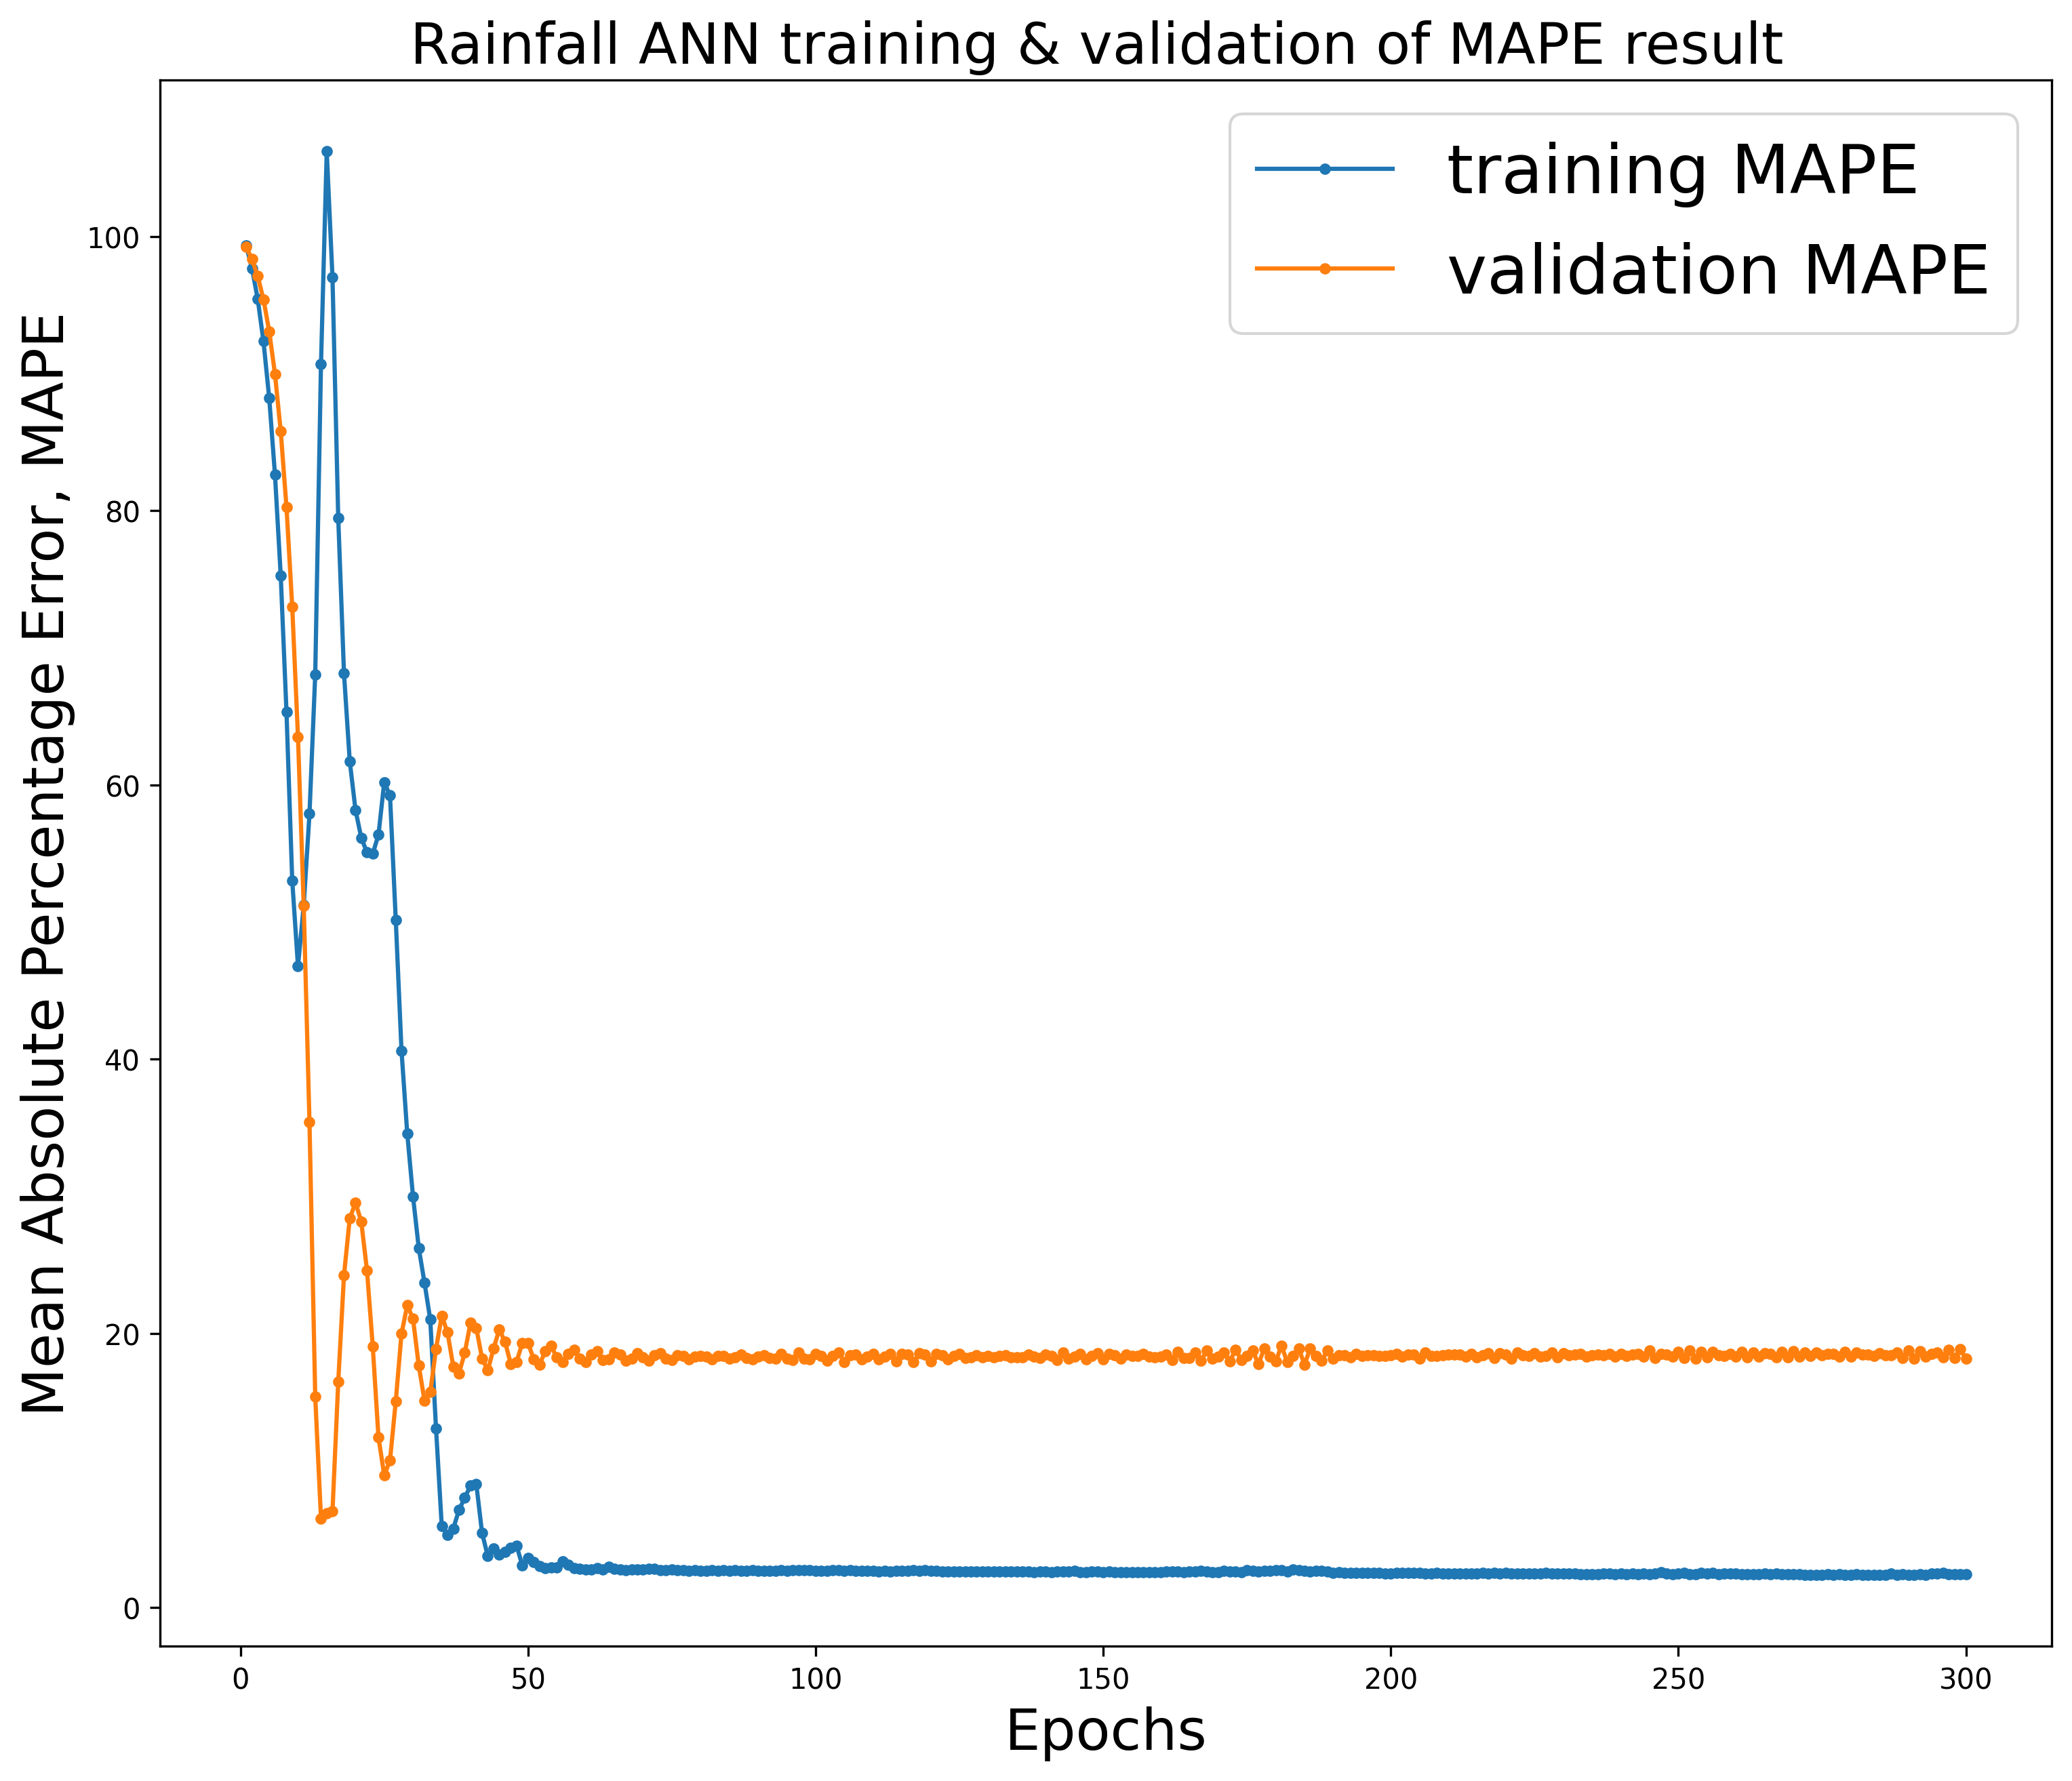

In [54]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Rainfall ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [395]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Y'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Y'].copy()

In [396]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='relu'))

# Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))

Fmodel.add(Dense(units=48, activation='relu'))

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.0005,beta_1=0.9)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 1)                 49        
                                                                 
Total params: 1,669
Trainable params: 1,669
Non-trainable params: 0
_________________________________________________________________


In [397]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=64,verbose=1)

Epoch 1/300
18/18 [==============================] - 0s 2ms/step - loss: 9.7496 - mean_absolute_percentage_error: 95.2305
Epoch 2/300
18/18 [==============================] - 0s 2ms/step - loss: 8.8551 - mean_absolute_percentage_error: 85.9055
Epoch 3/300
18/18 [==============================] - 0s 1ms/step - loss: 7.7150 - mean_absolute_percentage_error: 74.1546
Epoch 4/300
18/18 [==============================] - 0s 1ms/step - loss: 6.1461 - mean_absolute_percentage_error: 58.1084
Epoch 5/300
18/18 [==============================] - 0s 1ms/step - loss: 4.0309 - mean_absolute_percentage_error: 36.0191
Epoch 6/300
18/18 [==============================] - 0s 1ms/step - loss: 1.1897 - mean_absolute_percentage_error: 11.6718
Epoch 7/300
18/18 [==============================] - 0s 1ms/step - loss: 0.5449 - mean_absolute_percentage_error: 10.1241
Epoch 8/300
18/18 [==============================] - 0s 1ms/step - loss: 0.3898 - mean_absolute_percentage_error: 7.8566
Epoch 9/300
18/18 [======

In [398]:
# 7.3 Save the trained model
#Fmodel.save('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
Fmodel.save('')
print('Model has been saved...')

Model has been saved...


In [64]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('D:/Program_Files/Python/venv/venv/data/Timeseries Forecas/Forecast_RollingWindow_ANN_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [65]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Y'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Y'].copy()

In [66]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [13]:
# naive
pred_values = clean_df.iloc[1095:1095+157,:].drop(['Date','Lag_1', 'Lag_2', 'Lag_3'],axis=1).copy()
pred_values.index = [i + 1 for i in pred_values.index]


Results = pd.DataFrame({'Date': Forecast_test_data['Date'], 'Y_true': Forecast_test_data['Y']})


Results['Predict'] = pred_values


Results['abs Error'] = np.abs(Results['Y_true'] - Results['Predict'])

MAE = mean_absolute_error(Results['Y_true'], Results['Predict'])
MSE = mean_squared_error(Results['Y_true'], Results['Predict'], squared=True)
RMSE = mean_squared_error(Results['Y_true'], Results['Predict'], squared=False)
SMAPE = SMAPE_calulate(Results['Y_true'], Results['Predict'])
MdRAE = MdRAE_calculate(Results['Y_true'], Results['Predict'])

print('MAE:', round(MAE, 3))
print('MSE:', round(MSE, 3))
print('RMSE:', round(RMSE, 3))
print('SMAPE:', round(SMAPE, 3), '%')
print('MdRAE:', round(MdRAE[0], 3), 'bench:', round(MdRAE[1], 3))

MAE: 0.208
MSE: 0.081
RMSE: 0.285
SMAPE: 1.504 %
MdRAE: 0.204 bench: 13.909


In [67]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
# MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
# RAE=RAE_calculate(y_forecast_test,pred_values)
# MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
# RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
# RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
# print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
# print('RAE:',round(RAE,3))
# print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
# print('RSE:',round(RSE,3))
# print('RRSE:',round(RRSE,3))

MAE: 0.211
MSE: 0.083
RMSE: 0.287
SMAPE: 1.532 %
MdRAE: 0.227 bench: 13.909


#  Plot for comparing true value & predicted value 

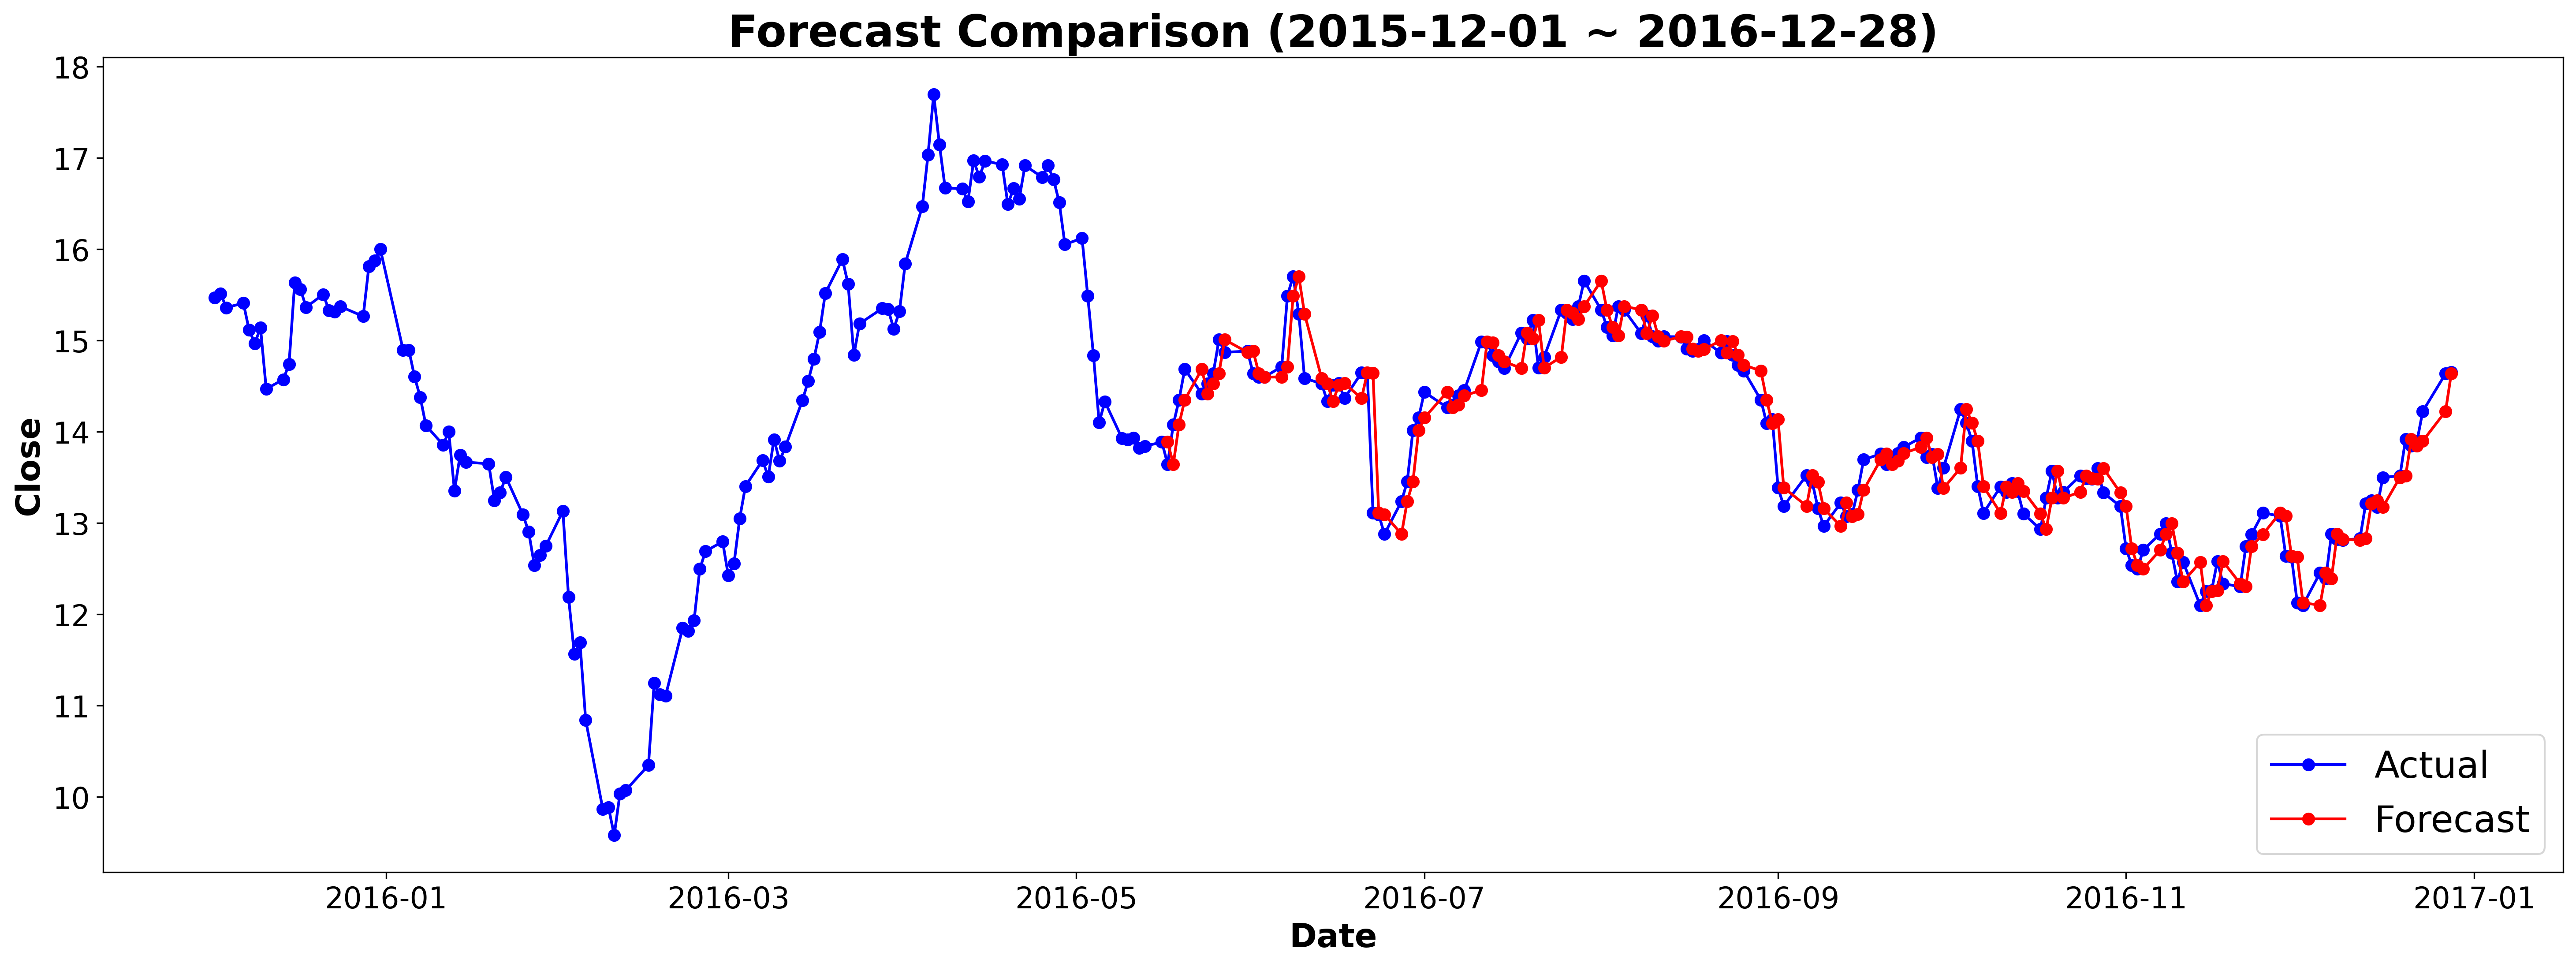

In [14]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Forecast Comparison (2015-12-01 ~ 2016-12-28)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[982:,0],clean_df.iloc[982:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

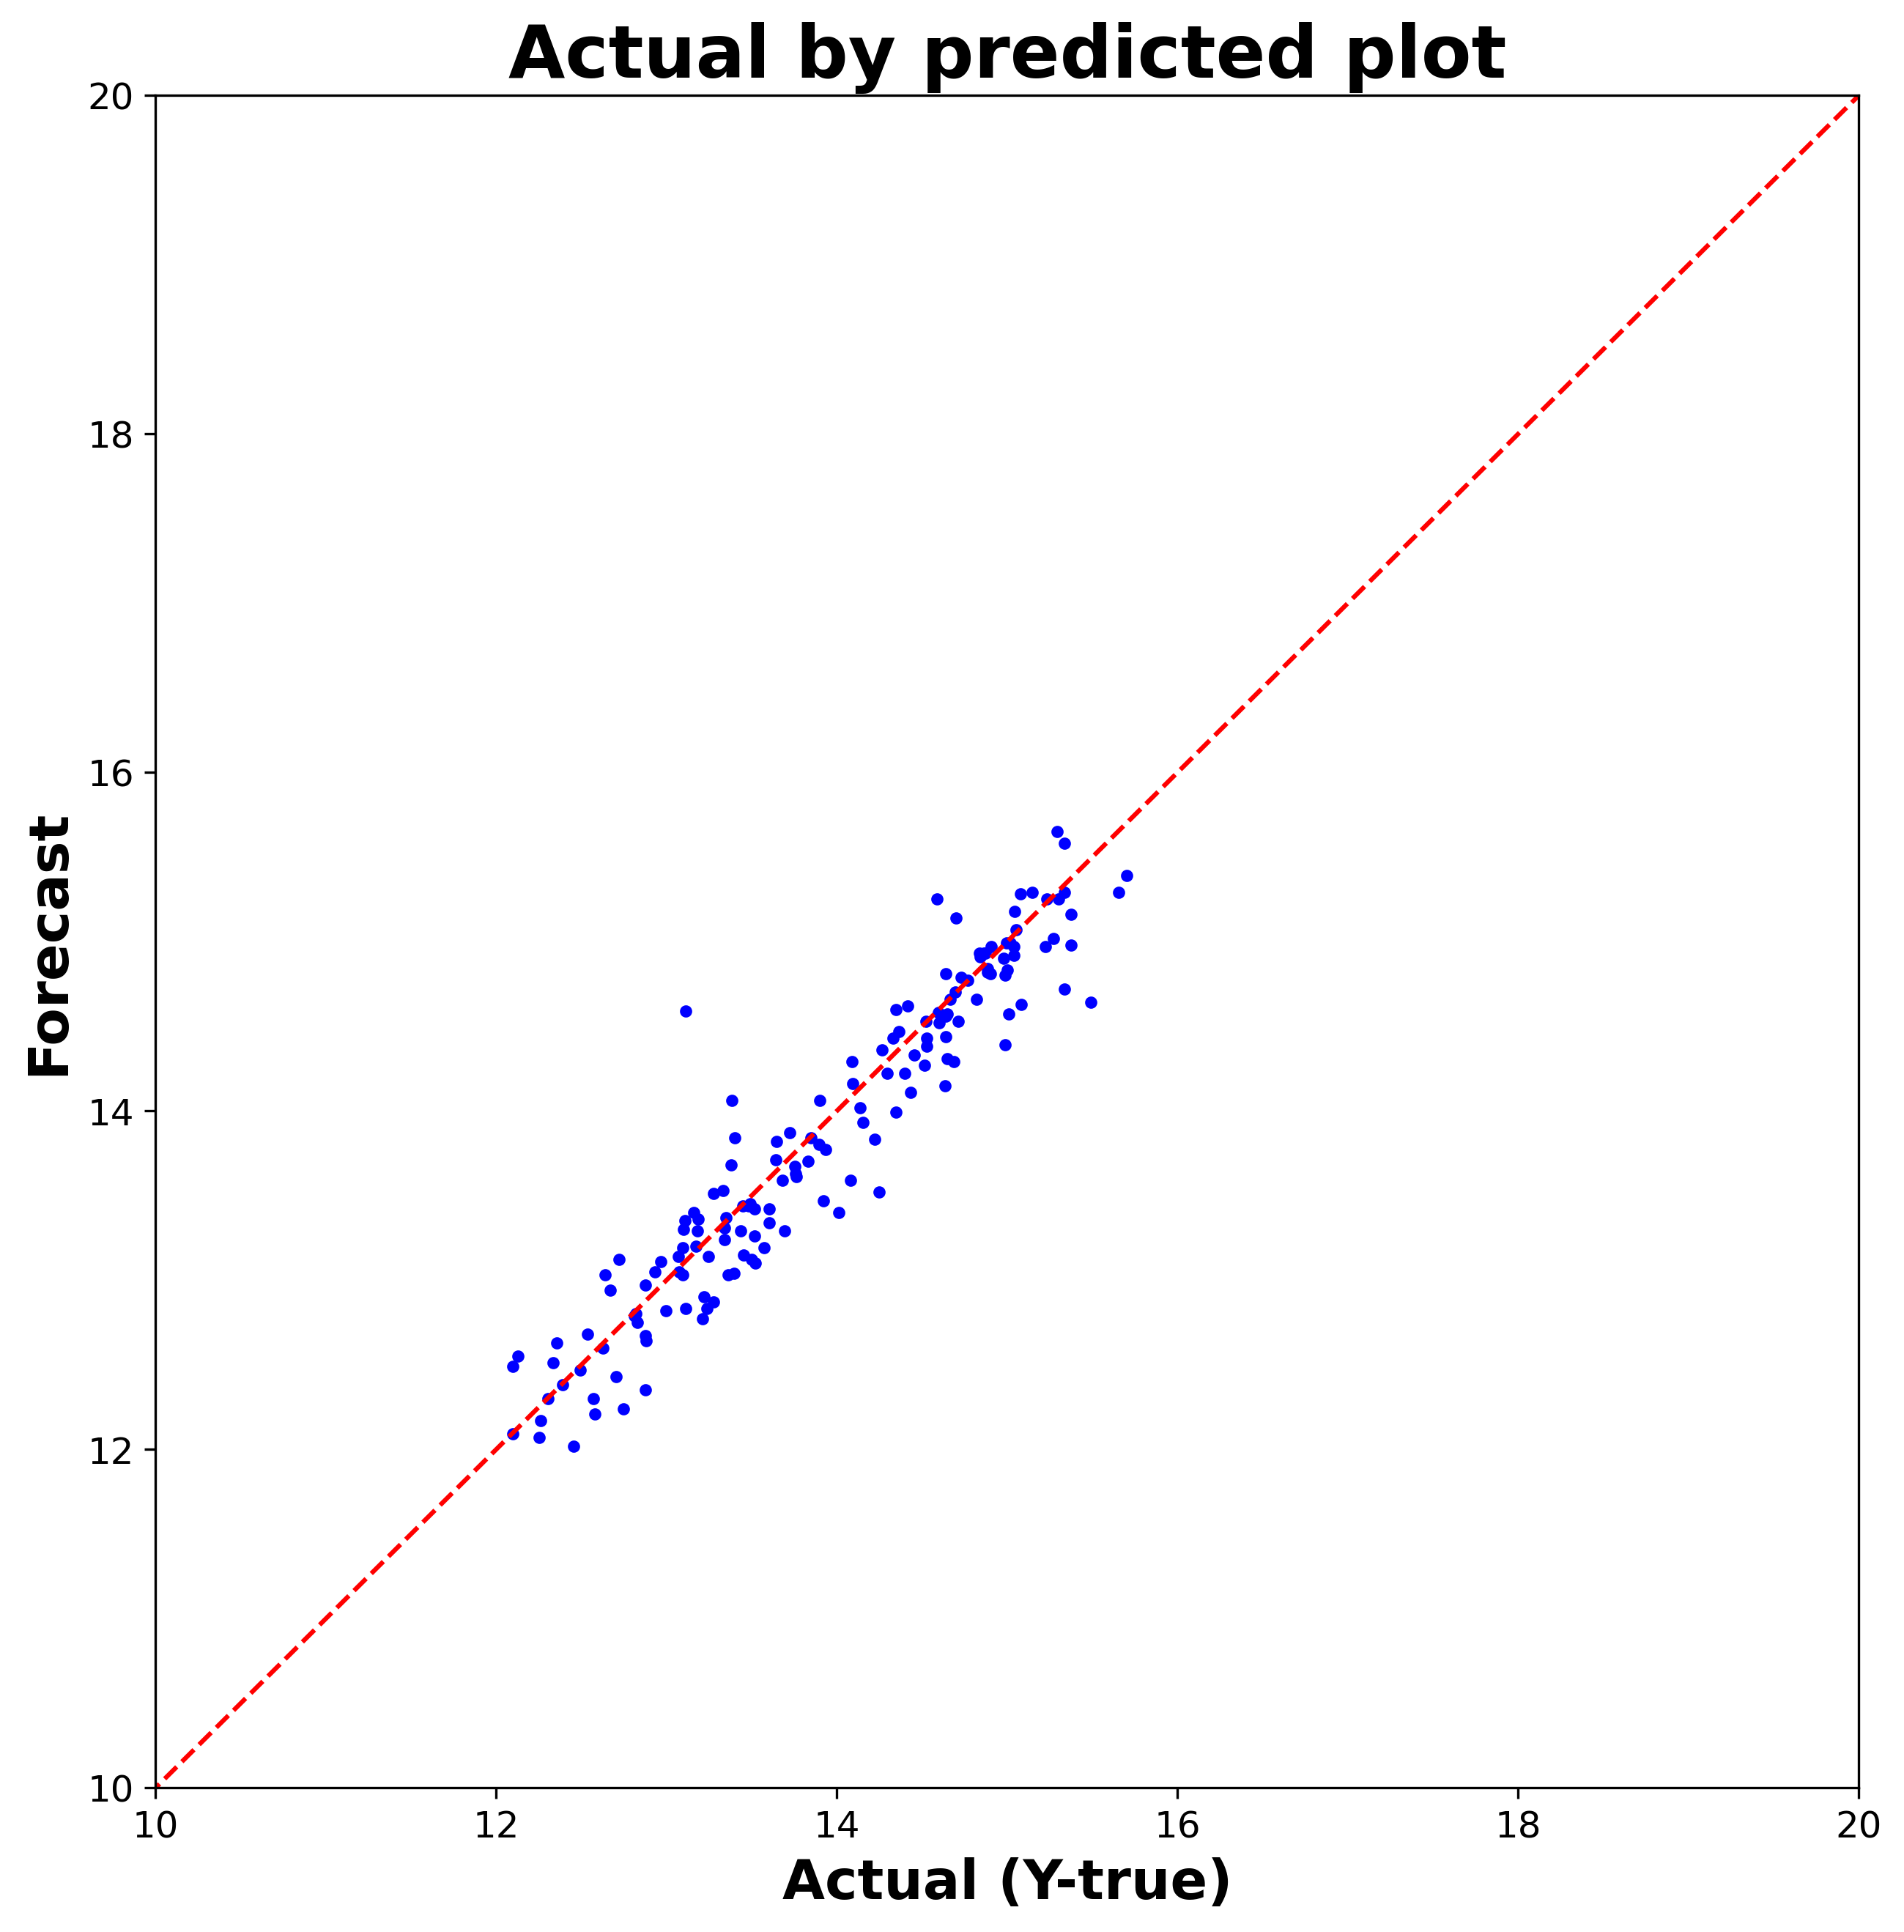

In [28]:
# Lock the scale of axis by Y_true
# max_value=100+5
# min_value=0-5
max_value=15+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(10,max_value)
plt.xlim(10,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()